This will explore how importance scores from three different methods compare on simulated data.

The simulated data was as follows:
- 2000 sequences with 1-5 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 2000 sequences with 1-5 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 2000 sequences with BOTH 1-5 instances of a GATA_disc1 motif AND 1-5 instances of a TAL1_known1 motif; these were labelled 1,1,1
- 42,000 sequences with no motif

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

First, we generate data to analyze. Let's make datasets with the same distribution of motifs as the data that the model was trained on (the model was not trained on this exact data)

In [2]:
%matplotlib inline

In [3]:
#This will produce a warning about embedding TAL1_known1 motifs, which is normal
!./prep_data.sh

generating the data
zipping up the files


Read in the data

In [4]:
import simdna.synthetic as synthetic
from avutils import file_processing as fp
from collections import OrderedDict
reload(synthetic)
data_filename = "sequences.simdata.gz"
#read in the data
data = OrderedDict()
for split in ['valid', 'test']:
    data[split] = synthetic.read_simdata_file(data_filename, ids_to_load=fp.read_rows_into_arr("splits/"+split+".txt.gz"))

Load the keras model and convert the models to the importance-scoring format. We will compare methods of deeplift, gradient\*input and guided backprop\*input.

In [5]:
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np
from deeplift.blobs import MxtsMode
import keras

#load the keras model

#50 dense layer nodes, trained with dropout
keras_model_weights = "model_files/record_1_model_brodc_modelWeights.h5"
keras_model_yaml = "model_files/record_1_model_brodc_modelYaml.yaml"

keras_model = kc.load_keras_model(weights=keras_model_weights,
                                  yaml=keras_model_yaml,
                                  normalise_conv_for_one_hot_encoded_input=True,
                                  name_of_conv_layer_to_normalise="conv1")

background = OrderedDict([('A', 0.27), ('C', 0.23), ('G', 0.23), ('T', 0.27)])

#set the reference to something with gc content of background
default = (np.ones((1,4,200))*np.array([background['A'],
                                        background['C'],
                                        background['G'],
                                        background['T']])[None,:,None]).astype('float32')

method_to_model = OrderedDict()
for method_name, mxts_mode in [('deeplift', MxtsMode.DeepLIFT),
                               ('grad_times_inp', MxtsMode.Gradient),
                               ('guided_backprop', MxtsMode.GuidedBackprop),
                               ('guided_backprop_deeplift', MxtsMode.GuidedBackpropDeepLIFT),
                               ('pos_through_dense_deeplift', MxtsMode.PosThroughDenseDeepLIFT),
                               ('counterbalance_dense_deeplift', MxtsMode.CounterBalanceDenseDeepLIFT)]:
    #'default' is another word for 'reference'
    method_to_model[method_name] = kc.convert_graph_model(model=keras_model, mxts_mode=mxts_mode, default=default)

Using gpu device 2: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
Using Theano backend.


/users/avanti/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


One-hot encode the sequence data

In [6]:
import avutils
import avutils.util

#get one-hot encoded data
onehot_data = OrderedDict()
for split in data:
    onehot_data[split] = np.array([avutils.util.seq_to_2d_image(seq) for seq in data[split].sequences])

Double-check that the conversion happened correctly by making sure both the original keras model and the converted models are giving the same predictions (this is not strictly necessary for computing importance scores)

In [7]:
#make sure predictions are the same as the original model
from deeplift import backend as B
deeplift_prediction_func = B.function([method_to_model['deeplift'].get_name_to_blob()['sequence'].get_activation_vars()],
                                       method_to_model['deeplift'].get_name_to_blob()['output_act'].get_activation_vars())
original_model_predictions = keras_model.predict({'sequence':onehot_data['test']}, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[onehot_data['test']],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions['output'])) < 10**-5
predictions = converted_model_predictions

Compute the importance scores using different methods

In [8]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("On method: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_name="sequence",
                                                                    pre_activation_target_layer_name="output_preact")

from collections import OrderedDict

split_to_method_to_task_to_scores = OrderedDict()
for split in ['valid','test']:
    print("Computing on split: "+split)
    method_to_task_to_scores = OrderedDict()
    for method_name, score_func in method_to_scoring_func.items():
        method_to_task_to_scores[method_name] = OrderedDict()
        for task_idx in [0,1,2]:
            scores = np.array(score_func(
                        task_idx=task_idx,
                        input_data_list=[onehot_data[split]],
                        batch_size=200,
                        progress_update=None))
            assert scores.shape[2]==4
            scores = np.squeeze(np.sum(scores, axis=2),axis=1)
            method_to_task_to_scores[method_name][task_idx] = scores
    split_to_method_to_task_to_scores[split] = method_to_task_to_scores

Compiling scoring functions
On method: deeplift
On method: grad_times_inp
On method: guided_backprop
On method: guided_backprop_deeplift
On method: pos_through_dense_deeplift
On method: counterbalance_dense_deeplift
Computing on split: valid
Computing on split: test


Compute the average scores and compare to log-odds scores for motif

In [11]:
import matplotlib.pyplot as plt
import simdna
from simdna import synthetic as sn
%matplotlib inline

split = 'test'
motif_to_top_N_log_odds_scores = OrderedDict()
motif_to_top_N_indices = OrderedDict()
motif_to_task_to_method_to_corresponding_score = OrderedDict()
motif_to_task_to_method_to_corresponding_score_norm = OrderedDict()

for motif_name in ['GATA_disc1', 'TAL1_known1']:
    #get the motif locations
    loaded_motifs = sn.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH,
                                        pseudocountProb=0.001,
                                        background=background)
    log_odds_mat = loaded_motifs.getPwm(motif_name).getLogOddsRows().T
    cross_corr_func = deeplift.util.get_cross_corr_function(filters=np.array([log_odds_mat]))
    log_odds_scores = np.squeeze(cross_corr_func(onehot_data[split], batch_size=20))
    motif_size = log_odds_mat.shape[-1]
    
    #for reach region, retain top 5 non-overlapping log-odds scores
    top_n_log_odds_scores, top_n_indices = deeplift.util.get_top_N_scores_per_region(
        log_odds_scores, N=5, exclude_hits_within_window=int(motif_size/2))
    
    motif_to_top_N_log_odds_scores[motif_name] = top_n_log_odds_scores
    motif_to_top_N_indices[motif_name] = top_n_indices
    
    #task -> method_num -> score_mat
    task_to_method_to_corresponding_score = OrderedDict()
    task_to_method_to_corresponding_score_norm = OrderedDict()
    motif_to_task_to_method_to_corresponding_score[motif_name] = task_to_method_to_corresponding_score
    motif_to_task_to_method_to_corresponding_score_norm[motif_name] = task_to_method_to_corresponding_score_norm
    
    #get the scores for different tasks and methods
    for task_idx, task_description in [
        (0, "0 (both-tal-and-gata)"),
        (1, '1 (gata-only)'),
        (2, '2 (tal-only)')]:
        
        task_to_method_to_corresponding_score[task_idx] = OrderedDict()
        task_to_method_to_corresponding_score_norm[task_idx] = OrderedDict()
    
        methods = ['deeplift',
                   'counterbalance_dense_deeplift',
                   'grad_times_inp',
                   'guided_backprop',
                   'guided_backprop_deeplift']
        
        for method in methods:
            
            scores = split_to_method_to_task_to_scores[split][method][task_idx]
            smoothen_function = deeplift.util.get_smoothen_function(motif_size, same_size_return=False)
            averaged_scores = np.array(smoothen_function(scores, batch_size=20))            
            
            #get the smoothed scores corresponding to the positives of the motifs
            corresponding_averaged_scores = []
            for scores_this_region, indices in zip(averaged_scores, top_n_indices):
                corresponding_averaged_scores.append([scores_this_region[idx] for idx in indices])
            
            task_to_method_to_corresponding_score[task_idx][method] = np.array(corresponding_averaged_scores)
            corresponding_averaged_scores_norm = corresponding_averaged_scores/np.std(corresponding_averaged_scores)
            task_to_method_to_corresponding_score_norm[task_idx][method] = corresponding_averaged_scores_norm            


In [14]:
corresponding_averaged_scores

[[0.02320678, 0.017816238, 0.012305479, 0.0033136953, 0.002275147],
 [0.86165577, 0.39073628, 0.39073628, 0.39073628, 0.39073628],
 [0.0097266603, 0.0018460536, 0.0030704567, 0.0025952575, 0.002646327],
 [0.10660775, 0.096672475, 0.0087887924, 0.0029252155, 0.013526666],
 [0.036891665, 0.0067414087, 0.004016127, 0.0028911848, 0.0032409267],
 [0.0034504139, 0.0023485774, 0.0035141432, 0.0029074072, 0.0025165447],
 [0.0039021901, 0.0033626866, 0.0022401353, 0.0024011256, 0.0020931477],
 [0.0069385706, 0.0061038095, 0.0030639912, 0.002998923, 0.0039505558],
 [0.0079204002, 0.0026012924, 0.0021072445, 0.0012930792, 0.0012930792],
 [0.0044350233, 0.0050222105, 0.0053605689, 0.002683436, 0.0016160788],
 [0.0056159864, 0.0026437643, 0.0024089387, 0.002117608, 0.0022672322],
 [0.0011544458, 0.0061817551, 0.0011772689, 0.001206925, 0.00202179],
 [0.003085772, 0.0025630603, 0.0021349029, 0.0048807049, 0.0037138828],
 [0.16556618, 0.0036593822, 0.0027232519, 0.0027232519, 0.0027232519],
 [0.00639

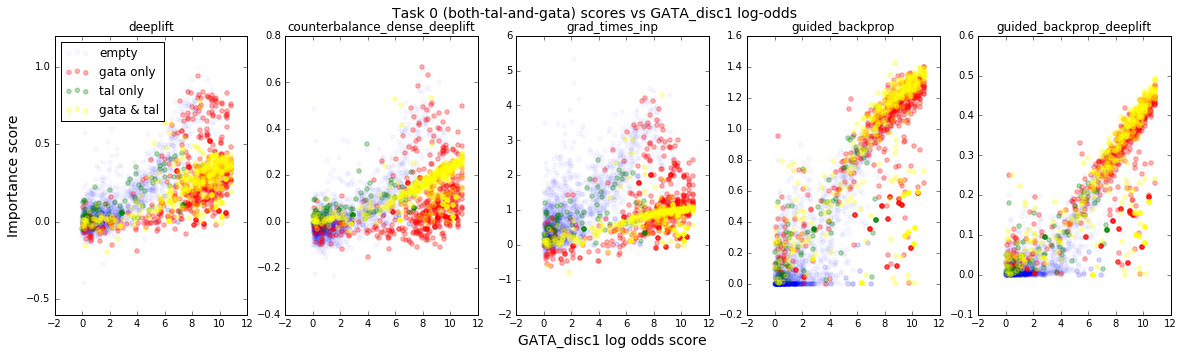

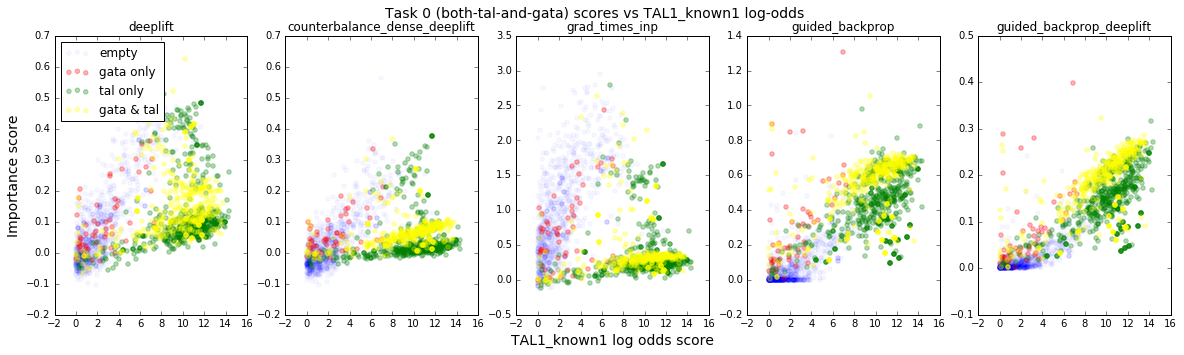

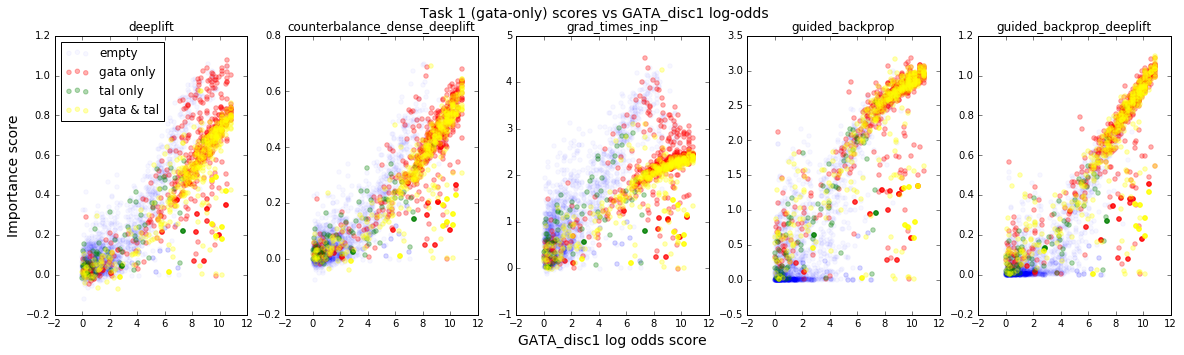

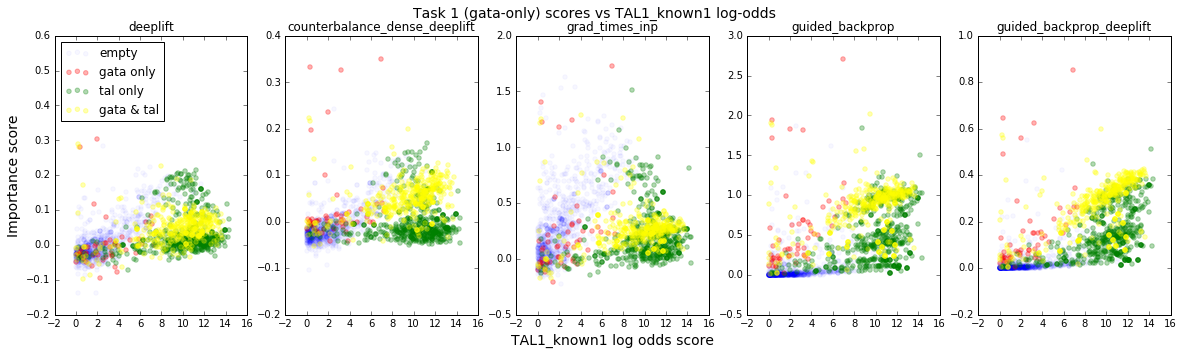

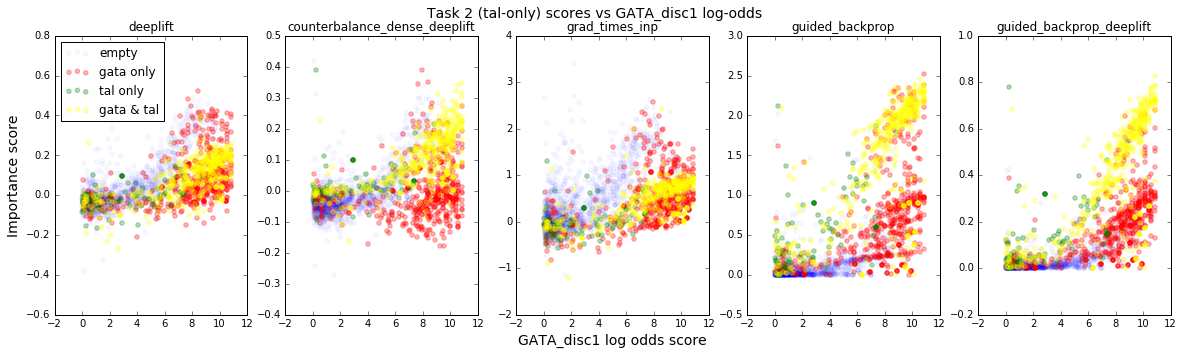

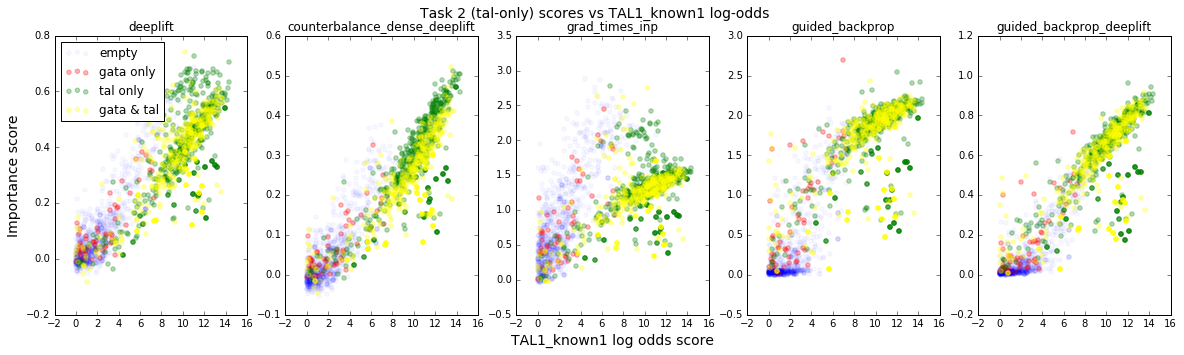

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

split = 'test'

for task_idx, task_description in [
    (0, "0 (both-tal-and-gata)"),
    (1, '1 (gata-only)'),
    (2, '2 (tal-only)')]:
    for motif_name in ['GATA_disc1', 'TAL1_known1']:
        
        fig = plt.figure(figsize=(20,5))
        fig.suptitle("Task "+task_description+" scores vs "+motif_name+" log-odds", fontsize=14)
        methods = ['deeplift',
                   'counterbalance_dense_deeplift',
                   'grad_times_inp',
                   'guided_backprop',
                   'guided_backprop_deeplift']
        
        for method_num, method in enumerate(methods):
            ax = plt.subplot(1,len(methods),method_num+1)
            legend_handles = []
            legend_labels = []
            
            
            for labels,alpha,color,legend_label in [[(0,0,0), 0.03, 'blue', 'empty'],
                                                   [(0,1,0), 0.3, 'red', 'gata only'],
                                                   [(0,0,1), 0.3, 'green', 'tal only'],
                                                   [(1,1,1), 0.3, 'yellow', 'gata & tal']]:            
                
                indices_to_keep_mask = [
                    True if (x[0]==labels[0] and x[1]==labels[1] and x[2]==labels[2])
                    else False for x in data[split].labels]
                
                log_odds_scores = np.compress(
                    condition=indices_to_keep_mask,
                    a=motif_to_top_N_log_odds_scores[motif_name],
                    axis=0)
                
                averaged_scores = np.compress(
                    condition=indices_to_keep_mask,
                    a=motif_to_task_to_method_to_corresponding_score[motif_name][task_idx][method],
                    axis=0)
                
                scatter_plot_coords =\
                 np.array([x for x in zip(log_odds_scores.ravel(), averaged_scores.ravel()) if x[0] > 0])
                the_plot = ax.scatter(scatter_plot_coords[:,0],scatter_plot_coords[:,1],
                               alpha=alpha,
                               color=color)
                legend_handles.append(the_plot)
                legend_labels.append(legend_label)
                
            if (method_num==0):
                ax.set_ylabel("Importance score", fontsize=14)
                ax.legend(handles=legend_handles, labels=legend_labels,loc=2)
            if (method_num==int(len(methods)/2)):
                ax.set_xlabel(motif_name+" log odds score", fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=10)
            ax.set_title(method)
            
        plt.show()


Organize info on the relevant motifs for each task

In [19]:
split_to_motif_locations = OrderedDict()
for split in data:
    motif_locations = {0:[], 1:[], 2:[]}
    split_to_motif_locations[split] = motif_locations
    for idx,embeddings in enumerate(data[split].embeddings):
        for task in motif_locations:
            motif_locations[task].append([])
        for embedding in embeddings:
            if ('TAL1_known1' in embedding.what.getDescription()):
                positive_tasks = [2]
                negative_tasks = [1]
            if ('GATA_disc1' in embedding.what.getDescription()):
                positive_tasks = [1]
                negative_tasks = [2]
            if (data[split].labels[idx][0]==1):
                positive_tasks += [0]
            else:
                negative_tasks += [0]
            for task in positive_tasks:
                motif_locations[task][-1].append((embedding.startPos, embedding.startPos+len(embedding.what),1))
            for task in negative_tasks:
                motif_locations[task][-1].append((embedding.startPos, embedding.startPos+len(embedding.what),-1))

In [20]:
def annotate_locations(pred_hits_per_region_tuples, motif_locations, motif_label, min_overlap=0.5):
    #for each region, will annotate a hit as a positive if it lies within min_overlap (a fraction) of a motif, and
    #as a negative otherwise. And put in any missed motifs as misses.
    #hits per region should be pairs of (start_index, end_index), one list per region
    hits_labels = []
    unmatched_hits = []
    for pred_hits_this_region, motif_locations_this_region in zip(pred_hits_per_region_tuples, motif_locations):
        #filter out the motifs that are not 'positive' for the task
        motif_locations_this_region = [x for x in motif_locations_this_region if x[2]==motif_label]
        
        hits_labels_this_region = []
        unmatched_motifs_set = set(range(len(motif_locations_this_region)))
        for hit_location in pred_hits_this_region:
            #check each motif to see if it overlaps
            found_match=False
            for motif_idx, motif_location in enumerate(motif_locations_this_region):
                #let's be conservative and allow only one true hit per motif.
                if (motif_idx in unmatched_motifs_set):
                    if (min(max(0,hit_location[1]-motif_location[0]),
                            max(0,motif_location[1]-hit_location[0]))
                        >= min_overlap*(motif_location[1]-motif_location[0])):
                        hits_labels_this_region.append(1)
                        found_match=True
                        unmatched_motifs_set.remove(motif_idx)
                        break
            if (not found_match):
                hits_labels_this_region.append(0)
        hits_labels.append(hits_labels_this_region)
        unmatched_hits.append(len(unmatched_motifs_set))
    return np.array(hits_labels), unmatched_hits

Looking at the score distribution of the negative set and how thresholds derived from them perform at finding motifs

In [21]:
#take the top N scores in a sliding window
def get_topN_scores(scores, topN, window_size, batch_size=20):
    smoothen_function = deeplift.util.get_smoothen_function(window_size, same_size_return=False)
    averaged_scores = np.array(smoothen_function(scores, batch_size=batch_size))
    #for reach region, retain top 5 non-overlapping log-odds scores
    top_n_log_odds_scores, top_n_indices =\
        deeplift.util.get_top_N_scores_per_region(
            averaged_scores, N=topN,
            exclude_hits_within_window=int(window_size/2.0))
    return top_n_log_odds_scores, top_n_indices

percentiles = [0.8, 0.9, 0.95, 0.99, 0.995, 0.999]
window_size=10
N=20
#learn the distribution of scores on the negative set from validation data
for task,task_description in [(1,"(GATA only)"),(2,"(TAL only)")]:
    print("Task: "+str(task)+" "+task_description)
    
    for method in split_to_method_to_task_to_scores['valid'].keys(): #the 'valid' doesn't mean anything, just get keys
        print("Method: "+str(method))
        scores_negative_set,\
        scores_test_set = [
            np.array([scores for scores,label in
                     zip(split_to_method_to_task_to_scores[split][method][task],
                        data[split].labels[:,task]) if label in target_labels])
            for (target_labels,split) in [([0],'valid'),([0,1],'test')]]
        
        (topN_scores_negative_set, _),\
        (topN_scores_test_set, topN_indices_test_set) = [
            get_topN_scores(
             scores=scores,
             topN=20,
             window_size=window_size)
            for scores in [scores_negative_set, scores_test_set]]
        
        
        #find different percentiles on the negative set
        sorted_scores_neg_set = sorted(np.array(topN_scores_negative_set).ravel())
        thresholds = []
        for percentile in percentiles:
            thresholds.append(sorted_scores_neg_set[int(percentile*len(sorted_scores_neg_set))])

        #annotate top_N_scores_test_set with whether or not it overlapped a real motif
        for motif_label in [1]:
            #print("For motif label "+str(motif_label))
            
            motif_locations_test_set = split_to_motif_locations['test'][task]

            pred_hit_labels, unmatched_hits = annotate_locations(
                pred_hits_per_region_tuples=[
                    [(start_idx, start_idx+window_size) for start_idx in indices_for_region]
                    for indices_for_region in topN_indices_test_set],
                motif_locations=motif_locations_test_set,
                motif_label=motif_label,
                min_overlap=0.5)

            total_unmatched_hits = sum(unmatched_hits)

            #zip up the positive scores to the labels
            scores_and_labels = np.array(zip(topN_scores_test_set.ravel(), pred_hit_labels.ravel()))

            total_motifs = np.sum(scores_and_labels[:,1]) + total_unmatched_hits

            #sanity check
            total_motifs_check = sum(len([x for x in motifs_this_region if x[2]==motif_label])
                                      for motifs_this_region in motif_locations_test_set)
            assert total_motifs == total_motifs_check, str(total_motifs)+" "+str(total_motifs_check)

            #at each threshold, compute precision and recall
            precisions = []
            recalls = []
            for threshold in thresholds:
                passing_threshold = [x[1] for x in scores_and_labels if x[0] >= threshold]
                true_positives = sum(passing_threshold)
                false_positives = len(passing_threshold) - true_positives
                false_negatives = total_motifs - true_positives
                precisions.append(float(true_positives)/(true_positives+false_positives))
                recalls.append(float(true_positives)/total_motifs)

            #augment scores and labels with the false negatives of totally-missed motifs
            #random.random() is to break ties which can throw off auPRC calculation
            import random
            arr_to_augment_with = np.array([[-100+random.random(), 1] for x in range(total_unmatched_hits)])
            if (len(arr_to_augment_with) > 0):
                augmented_scores_and_labels =\
                 np.concatenate([scores_and_labels, arr_to_augment_with], axis=0)
            else:
                augmented_scores_and_labels = scores_and_labels

            from sklearn.metrics import average_precision_score
            print("AuPRC (scikit): "+str(average_precision_score(augmented_scores_and_labels[:,1],
                                                                augmented_scores_and_labels[:,0])))

            #find the recall at different FDRs
            import avutils
            from avutils.perf_stats import recall_at_fdr_single_task
            recalls_and_fdrs = recall_at_fdr_single_task(predicted_scores=augmented_scores_and_labels[:,0],
                                      true_y=augmented_scores_and_labels[:,1],
                                      fdr_thresholds=[0.5,0.05])

            print("Recalls at different fdrs:")
            print("\n".join(str(fdr)+"\t"+str(recall) for fdr,recall in recalls_and_fdrs.items()))

            #print("Percentile vs. threshold vs. precision vs. recall")
            #print("\n".join("\t".join(str(round(val,3)) for val in vals)
            #                for vals in zip(percentiles, thresholds, precisions, recalls)))


Task: 1 (GATA only)
Method: deeplift
AuPRC (scikit): 0.570162897815
Recalls at different fdrs:
0.5	0.799168975069
0.05	0.00138504155125
Method: grad_times_inp
AuPRC (scikit): 0.364546655775
Recalls at different fdrs:
0.5	0.00415512465374
0.05	0.00138504155125
Method: guided_backprop
AuPRC (scikit): 0.802381904568
Recalls at different fdrs:
0.5	0.869806094183
0.05	0.00138504155125
Method: guided_backprop_deeplift
AuPRC (scikit): 0.773382745276
Recalls at different fdrs:
0.5	0.829639889197
0.05	0.31163434903
Method: pos_through_dense_deeplift
AuPRC (scikit): 0.79412069975
Recalls at different fdrs:
0.5	0.882271468144
0.05	0.318559556787
Method: counterbalance_dense_deeplift
AuPRC (scikit): 0.668807769934
Recalls at different fdrs:
0.5	0.818559556787
0.05	0.00138504155125
Task: 2 (TAL only)
Method: deeplift
AuPRC (scikit): 0.738005662362
Recalls at different fdrs:
0.5	0.939643347051
0.05	0.00411522633745
Method: grad_times_inp
AuPRC (scikit): 0.44266538871
Recalls at different fdrs:
0.5	0

Visualize the scores at the sequences predicted most confidently. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

Sorted by task 0
confidence: [ 0.99996674  1.          1.        ]
Scores for task: 0
11.5757
deeplift


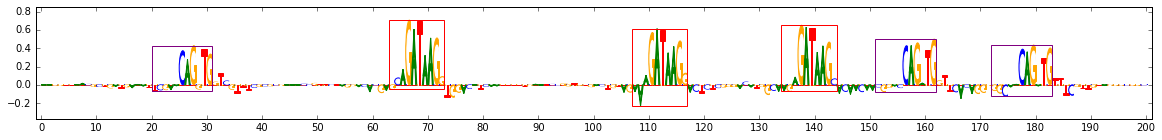

9.8996
counterbalance_dense_deeplift


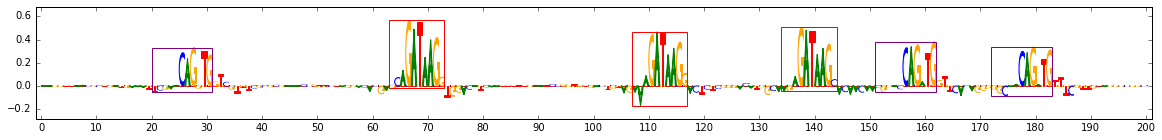

40.4771
grad_times_inp


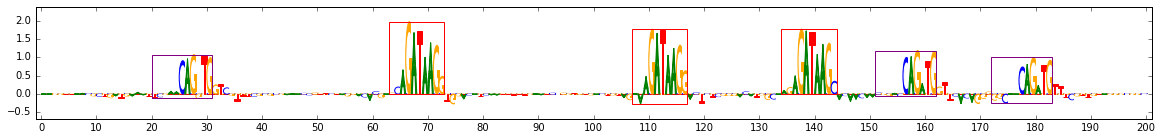

72.0754
guided_backprop


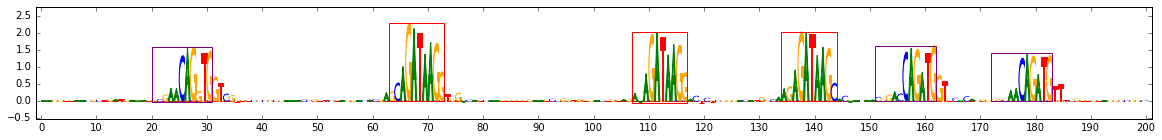

25.3356
guided_backprop_deeplift


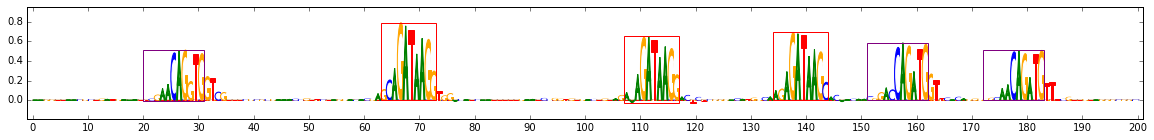

Scores for task: 1
17.5455
deeplift


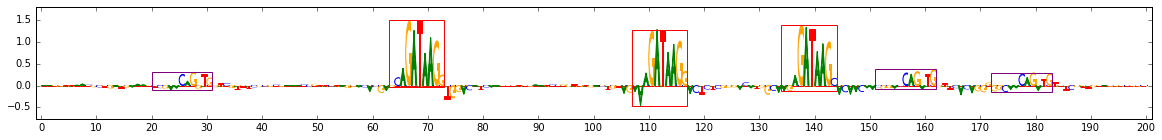

16.7561
counterbalance_dense_deeplift


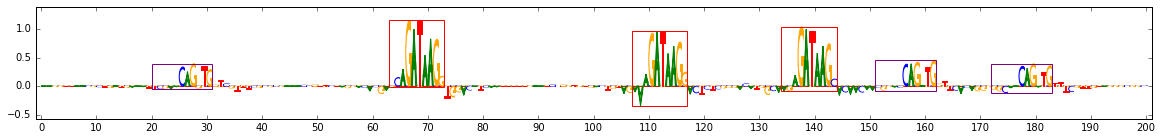

71.3208
grad_times_inp


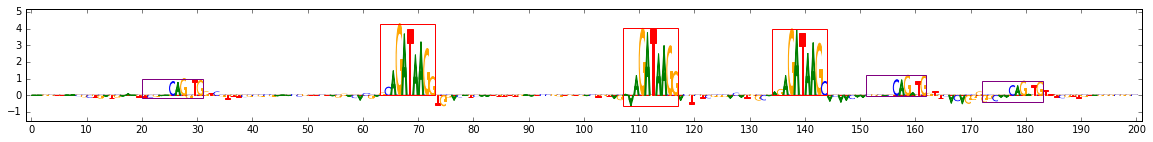

137.535
guided_backprop


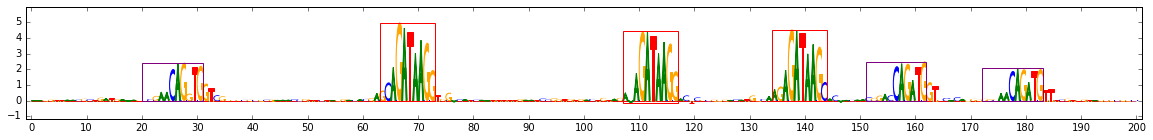

47.9141
guided_backprop_deeplift


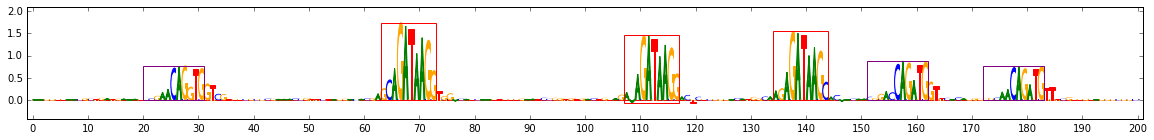

Scores for task: 2
22.6617
deeplift


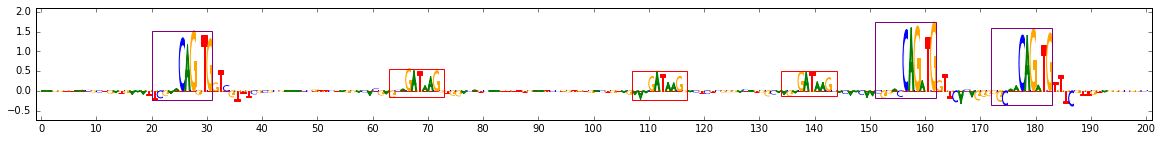

21.6341
counterbalance_dense_deeplift


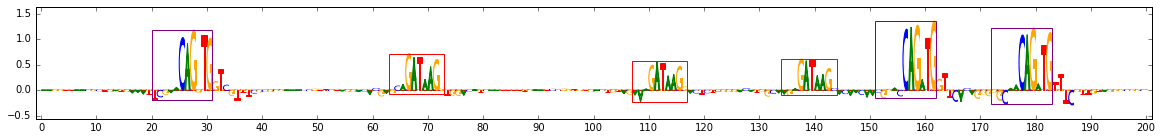

82.9941
grad_times_inp


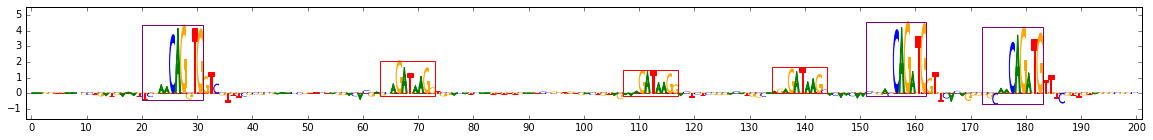

166.682
guided_backprop


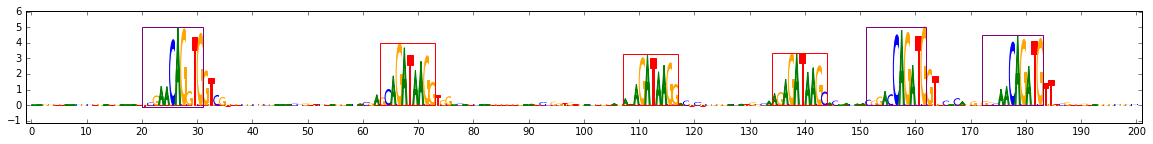

59.1843
guided_backprop_deeplift


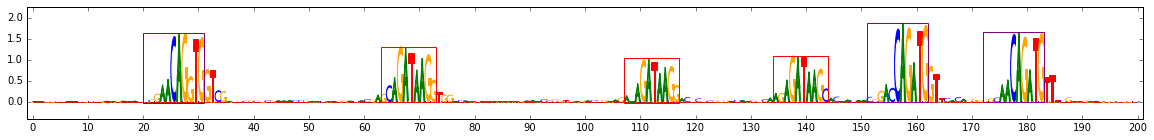

Sorted by task 1
confidence: [ 0.01146661  0.99999821  0.00110725]
Scores for task: 0
-3.19405
deeplift


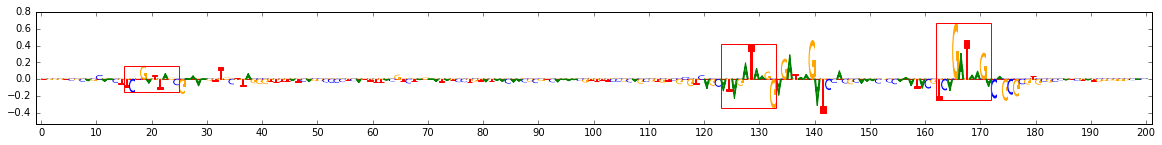

-4.27348
counterbalance_dense_deeplift


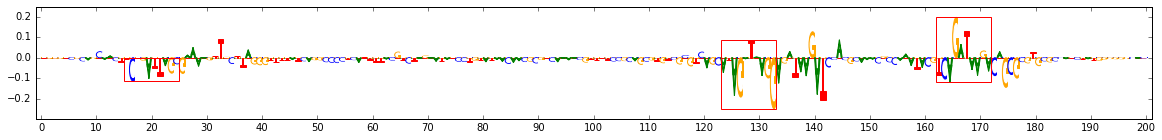

15.5749
grad_times_inp


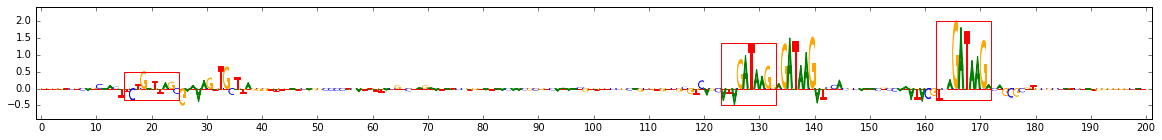

43.2199
guided_backprop


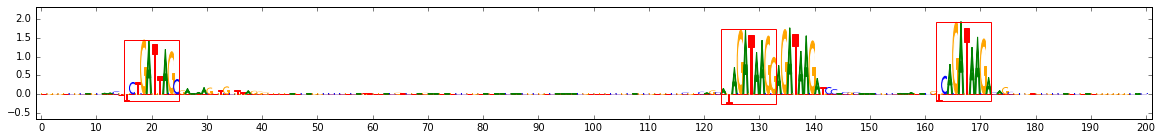

12.5909
guided_backprop_deeplift


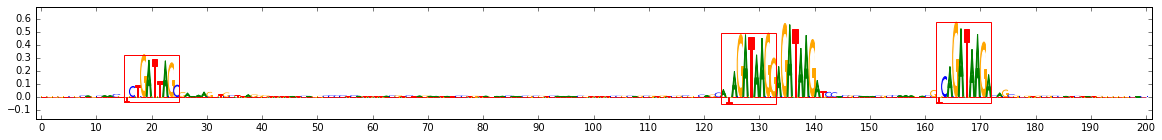

Scores for task: 1
14.0782
deeplift


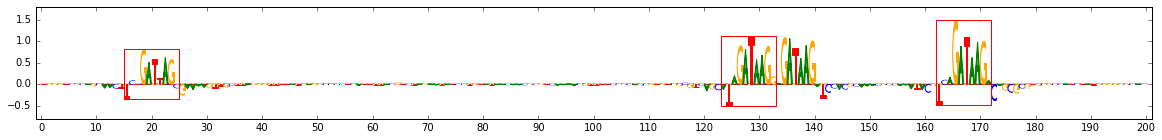

13.267
counterbalance_dense_deeplift


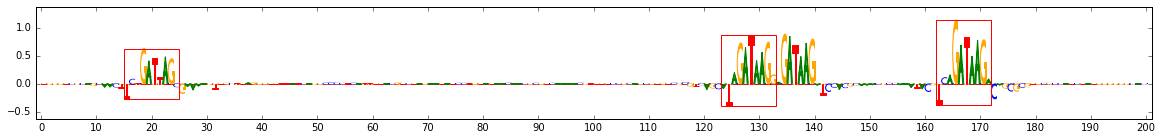

71.6749
grad_times_inp


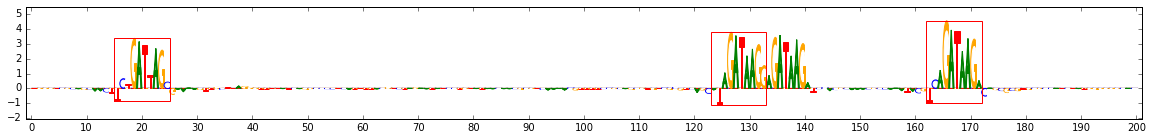

104.01
guided_backprop


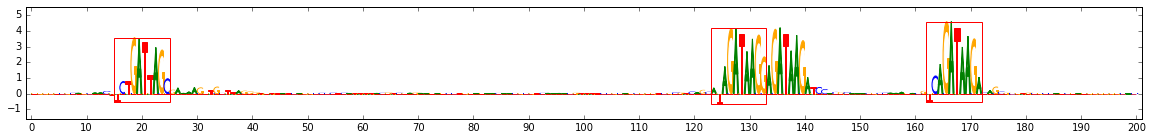

30.6685
guided_backprop_deeplift


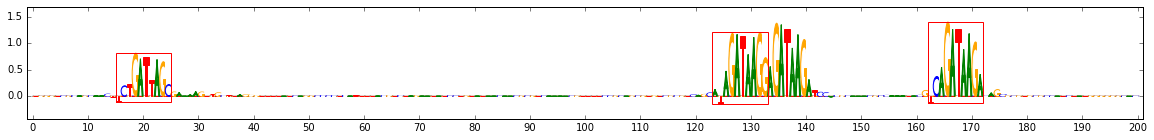

Scores for task: 2
-5.72303
deeplift


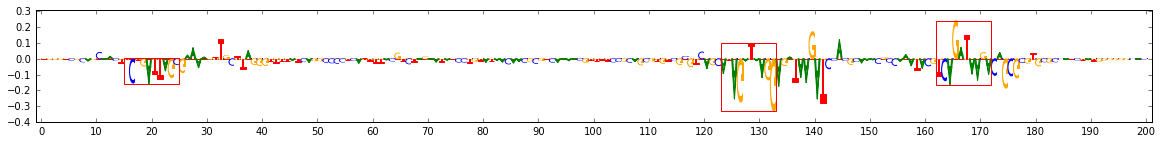

-6.2464
counterbalance_dense_deeplift


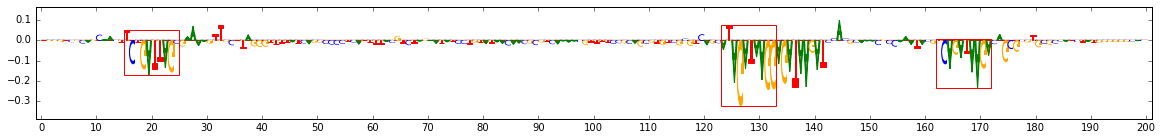

-0.9941
grad_times_inp


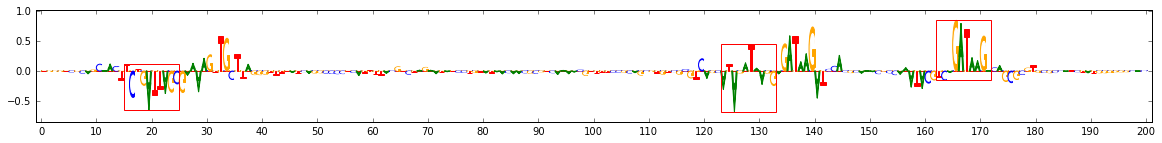

25.4072
guided_backprop


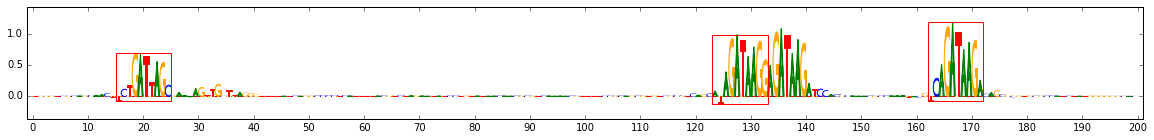

6.46192
guided_backprop_deeplift


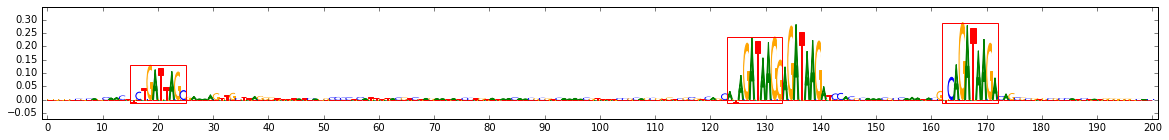

Sorted by task 2
confidence: [ 0.10026029  0.05155259  0.99227589]
Scores for task: 0
-0.931604
deeplift


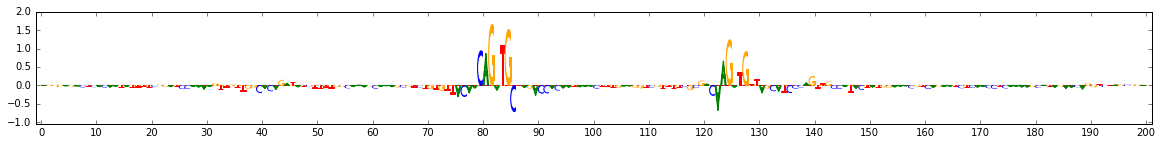

-1.92247
counterbalance_dense_deeplift


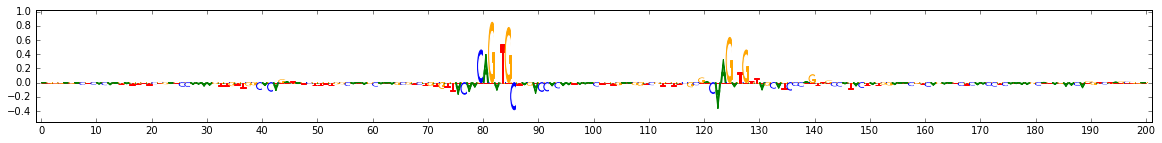

27.8114
grad_times_inp


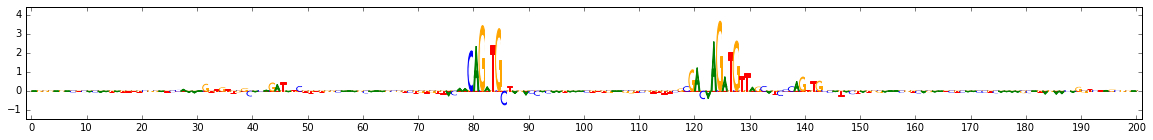

11.6214
guided_backprop


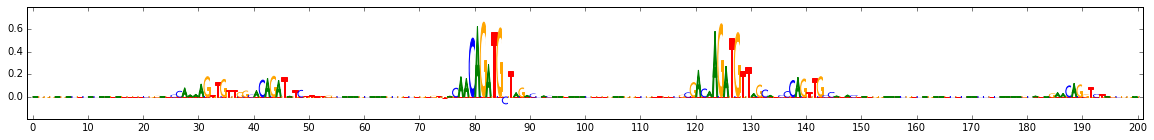

3.07571
guided_backprop_deeplift


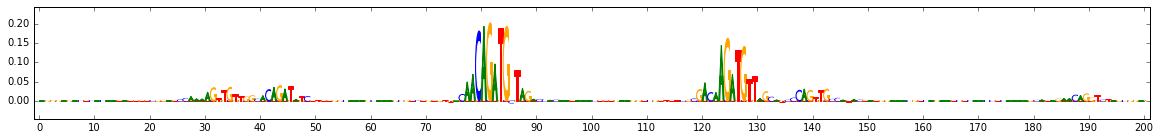

Scores for task: 1
-2.09822
deeplift


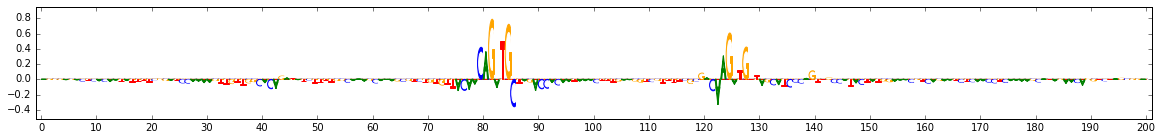

-2.37582
counterbalance_dense_deeplift


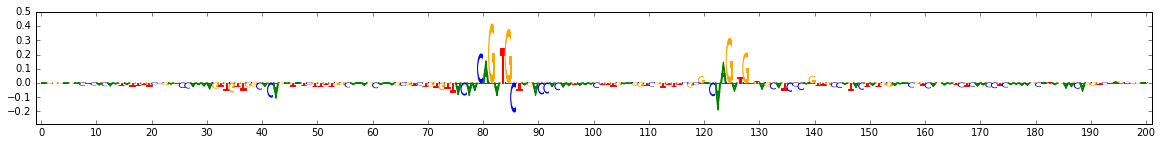

13.2966
grad_times_inp


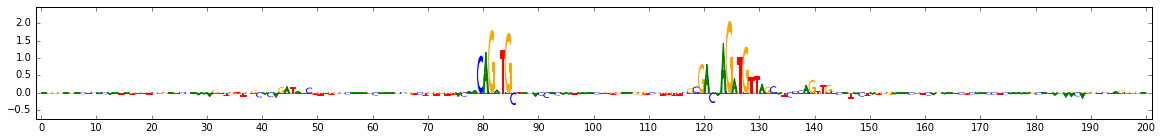

2.24001
guided_backprop


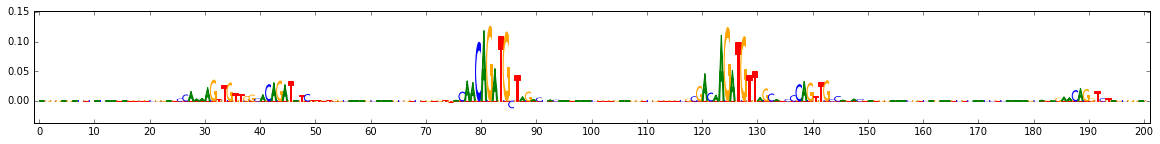

0.709387
guided_backprop_deeplift


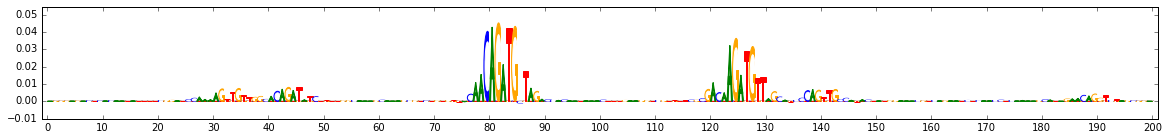

Scores for task: 2
5.93739
deeplift


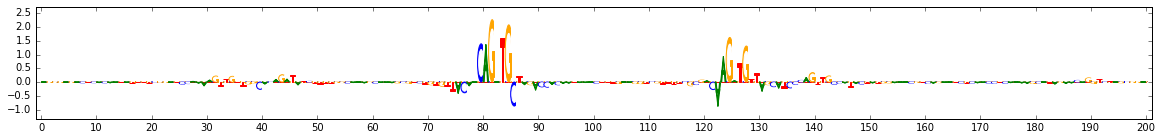

4.94334
counterbalance_dense_deeplift


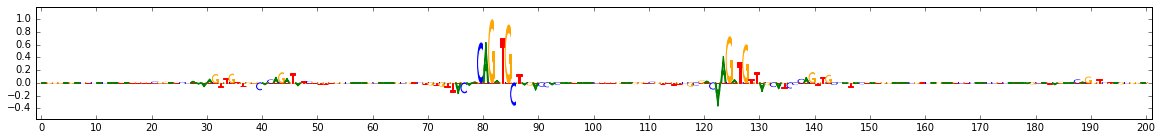

55.2101
grad_times_inp


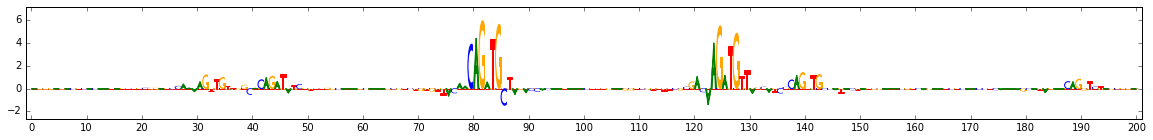

75.0379
guided_backprop


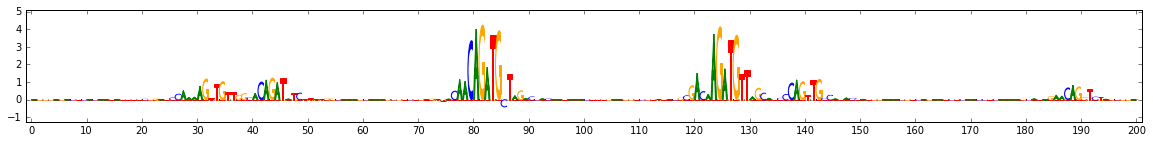

19.4243
guided_backprop_deeplift


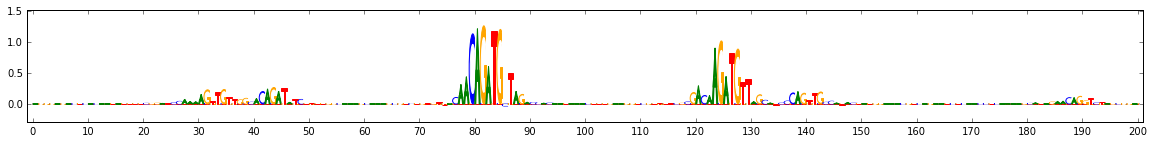

In [23]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence

sorted_predictions_by_task = [
    sorted(enumerate(predictions), key=lambda x: -x[1][0]),
    sorted(enumerate(predictions), key=lambda x: -(x[1][1]-x[1][2])),
    sorted(enumerate(predictions), key=lambda x: -(x[1][2]-x[1][1]))]

split='test'

for sort_task in [0,1,2]:
    print("Sorted by task "+str(sort_task))
    sorted_idx = 0
    idx = sorted_predictions_by_task[sort_task][sorted_idx][0]
    conf = sorted_predictions_by_task[sort_task][sorted_idx][1]
    print("confidence: "+str(conf))
    for task in [0,1,2]:
        print("Scores for task: "+str(task))
        for method_name in ['deeplift', 'counterbalance_dense_deeplift',
                            'grad_times_inp', 'guided_backprop',
                            'guided_backprop_deeplift']:
            scores = split_to_method_to_task_to_scores[split][method_name][task]
            scores_for_idx = scores[idx]
            print(np.sum(scores_for_idx))
            original_onehot = onehot_data[split][idx]
            scores_for_idx = original_onehot*scores_for_idx[None,None,:]
            print(method_name)
            highlight = {'red':[(start,end) for start,end,valid in motif_locations[1][idx] if valid==1],
                         'purple':[(start,end) for start,end,valid in motif_locations[2][idx] if valid==1]}
            viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)

Compute DeepLIFT scores on the channels

In [87]:
#Import some general util stuff
import sys, os
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

#import deepLIFT stuff
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils

In [88]:
task_idx=0
sequence_data_on_positives = np.array([data_onehot[i] for i in range(len(data.labels)) if data.labels[i][task_idx]==1])

In [89]:
model_to_use = deeplift_model

In [90]:
#compute scores of the channels
#computing deeplift scores on the conv layers
conv_layer_deeplift_contribs_func = model_to_use.get_target_contribs_func(
    find_scores_layer_name='conv1',
    pre_activation_target_layer_name="output_preact")
filter_contribs = np.array(conv_layer_deeplift_contribs_func(task_idx=task_idx,
        input_data_list=[sequence_data_on_positives],
        batch_size=200, progress_update=1000))
filter_contribs_revcomp = np.array(conv_layer_deeplift_contribs_func(task_idx=task_idx,
        input_data_list=[sequence_data_on_positives[:,:,::-1,::-1]],
        batch_size=200, progress_update=1000))

Done 0
Done 0


Visualize the top-scoring channels

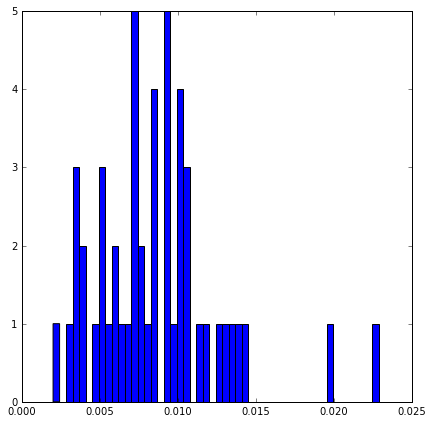

In [91]:
per_channel_scores = np.mean(np.squeeze(np.abs(filter_contribs))
                             +np.squeeze(np.abs(filter_contribs_revcomp)),axis=(-1,0))
#plot a histogram
from plottingUtilitiesPackage import matplotlibHelpers as mplh
reload(mplh)
mplh.plotHist(per_channel_scores,bins=50)

importance: 0.0228596 bias: -0.504632


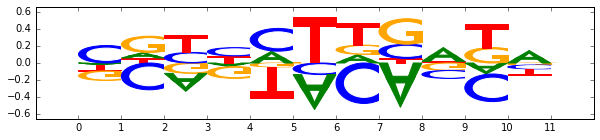

importance: 0.0197189 bias: -2.36772


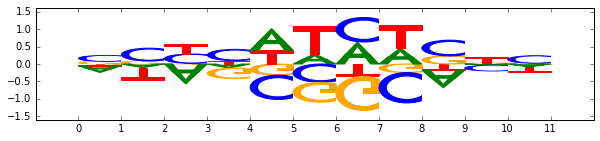

importance: 0.0142614 bias: -0.492065


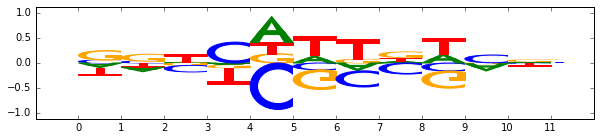

importance: 0.0140549 bias: -0.238519


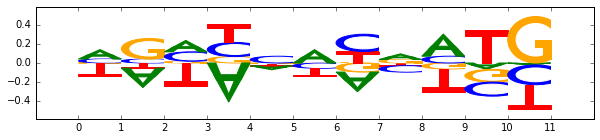

importance: 0.0134804 bias: -0.520951


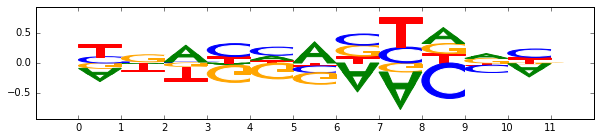

In [92]:
filter_weights, filter_biases = model_to_use.get_name_to_blob()['conv1'].W,\
                                model_to_use.get_name_to_blob()['conv1'].b

#sort filters by bias, plot weights
from deeplift.visualization import viz_sequence
filters_sorted_by_importance = sorted(zip(filter_weights, filter_biases, per_channel_scores), key=lambda x: -x[2])

for i in range(0,5):
    this_filter_bias = filters_sorted_by_importance[i][1]
    this_filter_weights = filters_sorted_by_importance[i][0]
    this_filter_importance = filters_sorted_by_importance[i][2]
    print("importance: "+str(this_filter_importance)+" bias: "+str(this_filter_bias))
    viz_sequence.plot_weights(np.squeeze(this_filter_weights), figsize=(10,2))

Compute the DeepLIFT scores and multipliers on the sequence

In [93]:
sequence_deeplift_contribs_func = model_to_use.get_target_contribs_func(
    find_scores_layer_name='sequence',
    pre_activation_target_layer_name='output_preact')
sequence_contribs = np.array(
                        sequence_deeplift_contribs_func(task_idx=task_idx,
                            input_data_list=[sequence_data_on_positives],
                            batch_size=200, progress_update=1000))
sequence_contribs = np.sum(sequence_contribs,axis=-2)[:,:,None,:]*sequence_data_on_positives

#computing multipliers on sequence
sequence_deeplift_multipliers_func = model_to_use.get_target_multipliers_func(
                                        find_scores_layer_name='sequence',
                                        pre_activation_target_layer_name='output_preact')
sequence_multipliers = np.array(sequence_deeplift_multipliers_func(task_idx=task_idx,
        input_data_list=[sequence_data_on_positives],
        batch_size=200, progress_update=1000))

Done 0
Done 0


Identify high-scoring segments

In [94]:
#identify the seqlets
reload(csi)
segmentIdentifier = csi.FixedWindowAroundPeaks(
                        slidingWindowForMaxSize=7,
                        flankToExpandAroundPeakSize=3,
                        excludePeaksWithinWindow=7,
                        ratioToTopPeakToInclude=0.3,
                        maxSegments=4)

seqlets, seqletIndices = csi.getSeqlets(
                                rawDeepLIFTContribs=sequence_contribs,
                                indicesToGetSeqletsOn=None,
                                revCompFunc=csi.dnaRevCompFunc,
                                outputsBeforeActivation=None, #don't worry about this
                                activation=None, #don't worry about this
                                thresholdProb=1.0, #don't worry about this
                                segmentIdentifier=segmentIdentifier,
                                numThreads=1,
                                secondsBetweenUpdates=1)

#filter out any shorter seqlets from the edges of sequences
maxSeqletLength = np.max([x.numUnderlyingObservations.shape[-1] for x in seqlets])
seqlets = [x for x in seqlets if x.numUnderlyingObservations.shape[-1] == maxSeqletLength]
seqlets_subset = seqlets[:]

Done 0 of 208
Done 100 of 208
Done 200 of 208


In [95]:
reload(csi)
import deeplift.util as deeplift_util
reload(deeplift_util)

#augment tracks
for (dataToAugmentWith,
     name,
     pseudocount,
     fullRevCompDataArr,
     revCompFunc,
     effectiveWidth,
     effectiveStride,
     layerFromAbove) in [
       (
            #note: multiplication by 1.0 is necessary to prevent integer overflow due to int8 or whatever
            np.squeeze(sequence_data_on_positives, axis=1)*1.0, #data (raw sequence here)
            "sequence", #name
             0.25, #pseudocount
             None, #fullRevCompDataArr
             csi.dnaRevCompFunc, #revCompFunc
             1, #effectiveWidth
             1, #effectiveStride
             False #layerFromAbove
        ),
       (
            np.squeeze(sequence_multipliers, axis=1), #data
            "sequence_multipliers", #name
            0.0, #pseudocount
            None, #fullRevCompDataArr
            csi.dnaRevCompFunc, #revCompFunc
            1, #effectiveWidth
            1, #effectiveStride
            False #layerFromAbove
        ),
        (
            np.squeeze(sequence_contribs, axis=1), #data
            "sequence_deeplift", #name
            0.0, #pseudocount
            None, #fullRevCompDataArr
            csi.dnaRevCompFunc, #revCompFunc
            1, #effectiveWidth
            1, #effectiveStride
            False #layerFromAbove
        ),
        (
            np.squeeze(filter_contribs, axis=2), #data
            "filter_deeplift", #name
            0.0, #pseudocount
            np.squeeze(filter_contribs_revcomp, axis=2), #fullRevCompDataArr
            None, #revCompFunc
            filter_weights.shape[-1], #effectiveWidth
            1, #effectiveStride
            True #layerFromAbove
        )
]:
    csi.augmentSeqletsWithData(
        seqlets_subset,
        fullDataArr=dataToAugmentWith,
        keyName=name,
        pseudocount=pseudocount,
        fullRevCompDataArr=fullRevCompDataArr,
        revCompFunc=revCompFunc,
        indicesToSubset=None,
        effectiveStride=effectiveStride,
        effectiveWidth=effectiveWidth,
        layerFromAbove=layerFromAbove,
        fillValue=0)

('idx', 0)
85


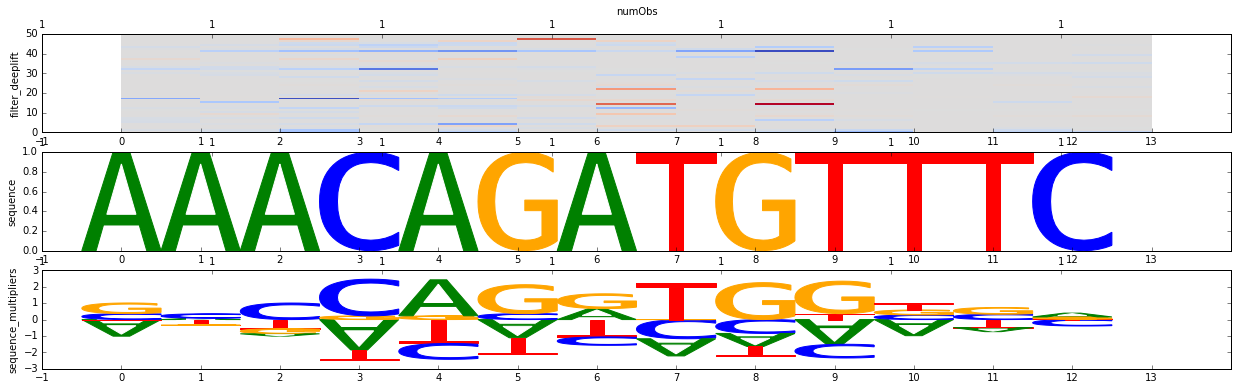

('idx', 0, 'reverse')


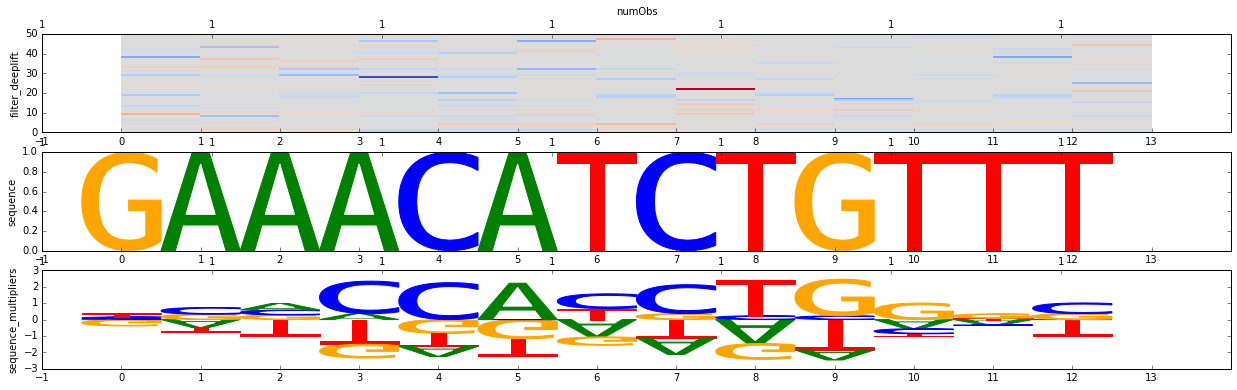

('idx', 1)
181


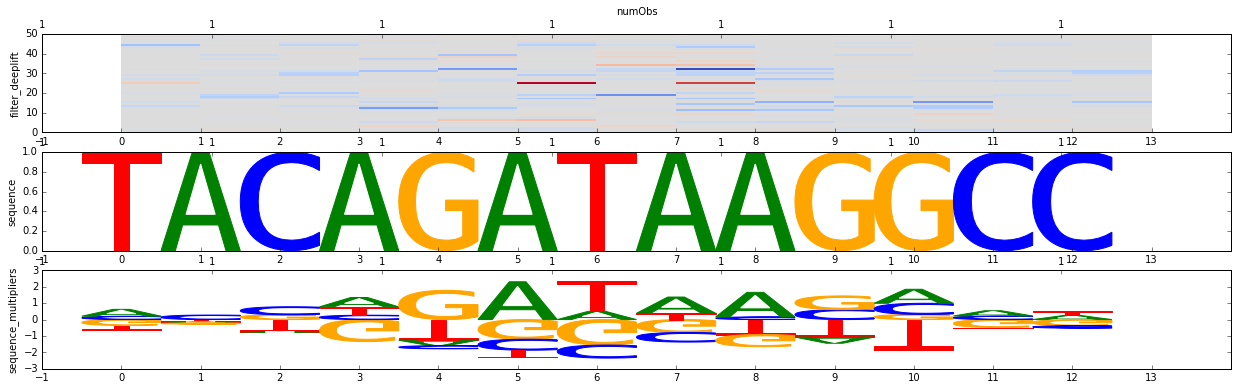

('idx', 1, 'reverse')


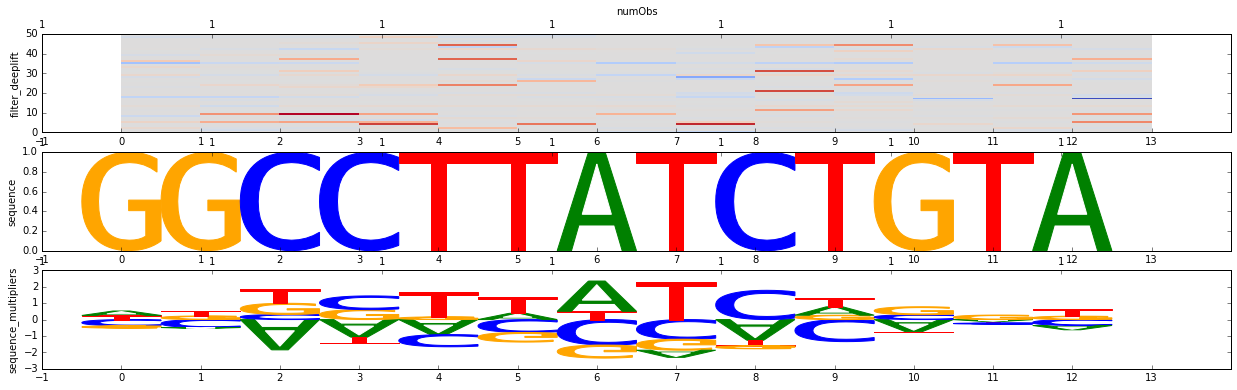

('idx', 2)
111


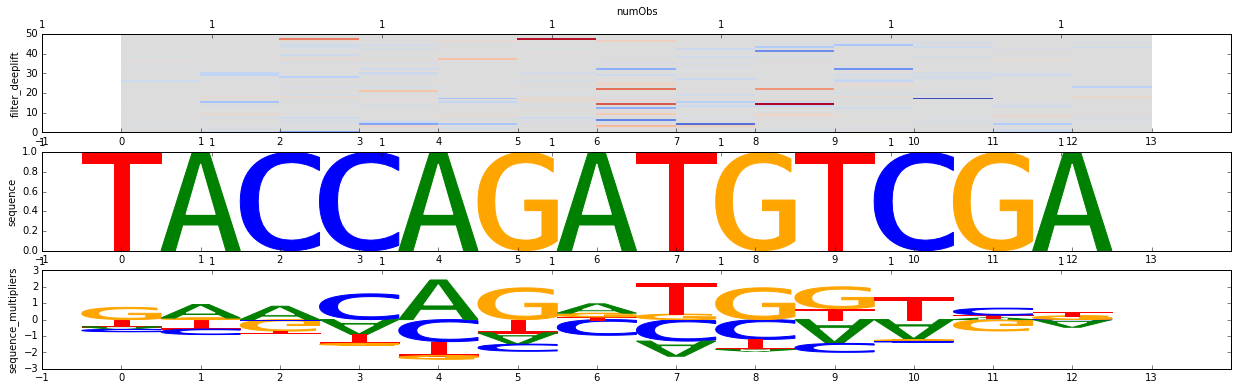

('idx', 2, 'reverse')


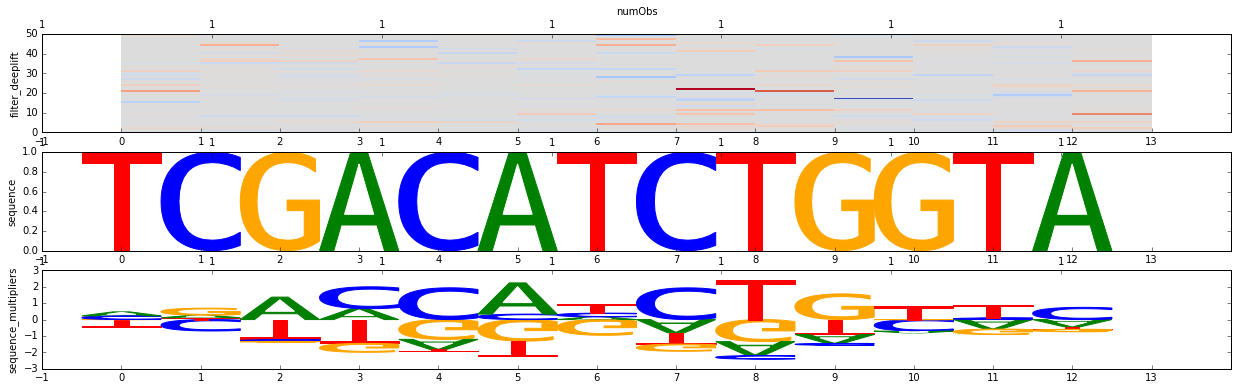

In [96]:
#visually explore some seqlets as a sanity check
reload(csi)
trackNamesToPrint=["filter_deeplift", "sequence", "sequence_multipliers"]
for idx in range(0,3):
    print("idx",idx)
    print(seqlets[idx].sequenceId)
    csi.printGrammar(seqlets[idx], trackNamesToPrint=trackNamesToPrint, heightPerTrack=2);
    print("idx",idx,"reverse")
    csi.printGrammar(seqlets[idx].getRevCompGrammar(), trackNamesToPrint=trackNamesToPrint, heightPerTrack=2)

In [97]:
reload(util)
reload(csi)
seqlets_corr_mat = csi.getCorrelationMatrix(
                        seqlets_subset,
                        subtracksToInclude=["filter_deeplift"],
                        accountForRevComp=True,
                        numThreads=None,
                        secondsBetweenUpdates=3,
                        xcorBatchSize=50)

Num words: 441 and 441
('On filters', 0, 'to', 1538)
Done 0
('On filters', 0, 'to', 1538)
Done 0
Seconds to compute corr mat: 1.10461807251


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 441 / 441
[t-SNE] Mean sigma: 0.136734
[t-SNE] Iteration 25: error = 0.7915603, gradient norm = 0.0213961
[t-SNE] Iteration 50: error = 0.8370551, gradient norm = 0.0192268
[t-SNE] Iteration 75: error = 0.6212670, gradient norm = 0.0159830
[t-SNE] Iteration 100: error = 0.6883430, gradient norm = 0.0145070
[t-SNE] Error after 100 iterations with early exaggeration: 0.688343
[t-SNE] Iteration 125: error = 0.5631322, gradient norm = 0.0132076
[t-SNE] Iteration 150: error = 0.6441950, gradient norm = 0.0139878
[t-SNE] Iteration 175: error = 0.6804400, gradient norm = 0.0135225
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 0.680440


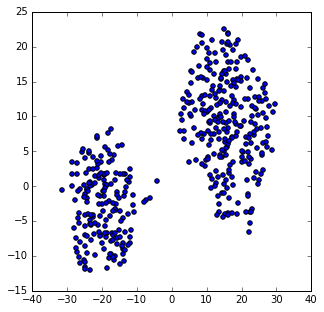

In [98]:
#find the t-sne embedding using the distance metric
reload(csi)
np.random.seed(1234)
embedding_corr = csi.getTsneEmbeddingOfGrammars(seqlets_corr_mat, perplexity=50, verbose=2)
mplh.scatterPlot(embedding_corr)

In [99]:
import sklearn.cluster
kmeans_clusters = sklearn.cluster.KMeans(n_clusters=2, n_init=10).fit_predict(embedding_corr)

No colors supplied, so autogen'd as:
(0, [0.0, 1.0, 0.0])
(1, [0.0, 0.0, 1.0])


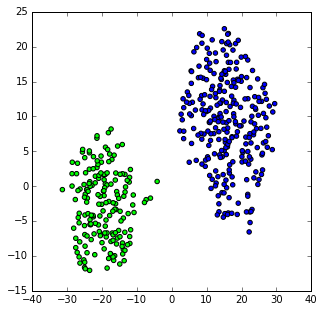

In [100]:
mplh.scatterPlot(embedding_corr, labels=kmeans_clusters)

In [101]:
merged_motifs = csi.createMergedGrammars(kmeans_clusters, seqlets
                                          , subtracksToInclude=["sequence_multipliers"]
                                          , accountForRevComp=True)
trimming_func = csi.TrimArrayColumnsToNumUnderlyingObs(0.5)
merged_motifs = csi.adjustGrammarsUsingTrimmingCriterion(merged_motifs,trimmingFunc=trimming_func)

('fwd motif', 0)


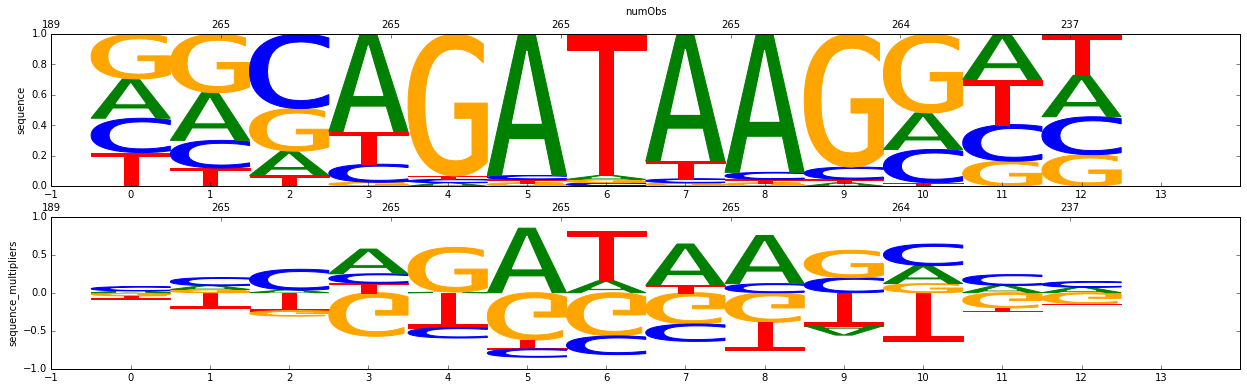

('rev motif', 0)


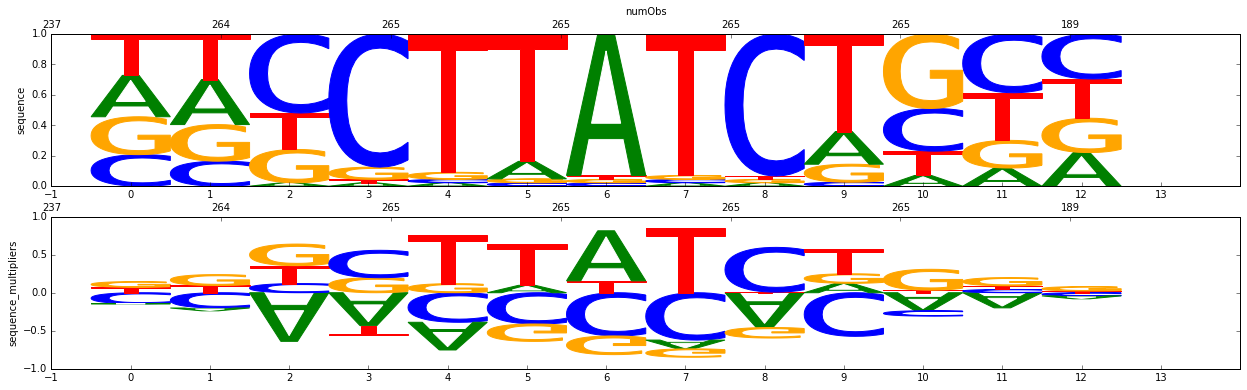

('fwd motif', 1)


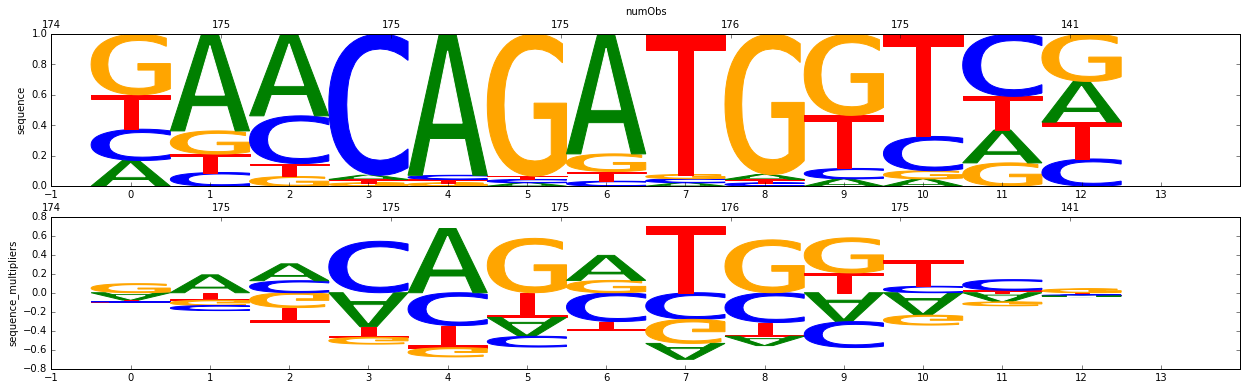

('rev motif', 1)


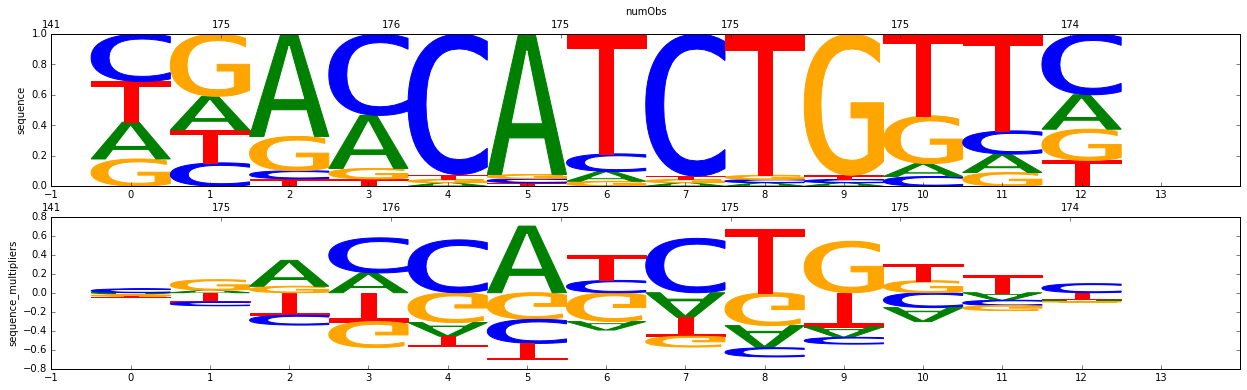

In [102]:
for idx, motif  in enumerate(sorted(merged_motifs.values(), key=lambda x: -x.totalObservationsEver)):
    print("fwd motif",idx)
    csi.printGrammar(motif, trackNamesToPrint=["sequence",
                                                 "sequence_multipliers"])
    print("rev motif",idx)
    csi.printGrammar(motif.getRevCompGrammar(), trackNamesToPrint=["sequence",
                                                 "sequence_multipliers"])